In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Standard MM1 Queue Simulator Class

In [4]:
class NonStationaryMM1:
    def __init__(self, arrival_rate_func, service_rate_func, T_end, 
                 initial_queue_length=0, max_queue_length=None, 
                 time_step=0.1, collect_waiting_times=True, max_departures=115000):
        """
         Non-stationary M/M/1 queue simulation
        
        Parameters:
        arrival_rate_func (callable): Function λ(t) returning arrival rate at time t
        service_rate_func (callable): Function μ(t) returning service rate at time t
        T_end (float): End time for simulation
        initial_queue_length (int): Starting number of vehicles in queue
        max_queue_length (int): Maximum allowed queue length (None for unlimited)
        time_step (float): Time resolution for statistics collection
        collect_waiting_times (bool): Whether to collect individual waiting times
        max_departures (int): Maximum number of departures before stopping
        """
        self.lambda_t = arrival_rate_func
        self.mu_t = service_rate_func
        self.T_end = T_end
        self.max_queue_length = max_queue_length
        self.time_step = time_step
        self.max_departures = max_departures
        
        # State variables
        self.current_time = 0.0
        self.queue_length = initial_queue_length
        self.next_arrival_time = self.generate_next_arrival_time(0)
        self.next_departure_time = float('inf')
        
        # Enhanced statistics
        self.queue_length_history = []
        self.time_history = []
        self.waiting_times = [] if collect_waiting_times else None
        self.arrival_times = {}  # Dictionary to track arrival times of each customer
        self.customer_id = 0     # Unique ID for each customer
        
        # Performance metrics
        self.total_arrivals = 0
        self.total_departures = 0
        self.total_waiting_time = 0
        self.rejected_arrivals = 0  # Count of arrivals rejected due to max queue length

    def generate_next_arrival_time(self, current_time):
        """
        Generate time until next arrival using non-homogeneous Poisson process
        """
        U = np.random.random()
        dt = -np.log(U) / self.lambda_t(current_time)
        return current_time + dt
    
    def generate_service_time(self):
        return 90.1 

    def generate_service_time(self, current_time):
        """
        Generate service time using current service rate
        """
        U = np.random.random()
        return -np.log(U) / self.mu_t(current_time)
        
    def step(self):
        """
        Enhanced step function with more statistics collection
        """
        # Record current state
        self.queue_length_history.append(self.queue_length)
        self.time_history.append(self.current_time)
        
        # Determine next event type
        if self.next_arrival_time <= self.next_departure_time:
            # Handle arrival
            self.current_time = self.next_arrival_time
            
            # Check max queue length
            if self.max_queue_length is None or self.queue_length < self.max_queue_length:
                self.queue_length += 1
                self.total_arrivals += 1
                
                # Track arrival time
                self.customer_id += 1
                self.arrival_times[self.customer_id] = self.current_time
                
                # If this is the only customer, schedule their departure
                if self.queue_length == 1:
                    service_time = self.generate_service_time(self.current_time)
                    self.next_departure_time = self.current_time + service_time
            else:
                self.rejected_arrivals += 1
                
            self.next_arrival_time = self.generate_next_arrival_time(self.current_time)
            
        else:
            # Handle departure
            self.current_time = self.next_departure_time
            self.queue_length -= 1
            self.total_departures += 1
            
            # Calculate waiting time for departing customer
            if self.waiting_times is not None:
                departed_customer = min(self.arrival_times.keys())
                waiting_time = self.current_time - self.arrival_times[departed_customer]
                self.waiting_times.append(waiting_time)
                self.total_waiting_time += waiting_time
                del self.arrival_times[departed_customer]
            
            # Schedule next departure if queue is not empty
            if self.queue_length > 0:
                service_time = self.generate_service_time(self.current_time)
                self.next_departure_time = self.current_time + service_time
            else:
                self.next_departure_time = float('inf')


    def run_simulation(self):
        """
        Run simulation until T_end or max_departures is reached
        """
        while self.current_time < self.T_end and self.total_departures < self.max_departures:
            self.step()
    
    def get_statistics(self):
        """
        Return summary statistics of the simulation
        """
        stats = {
            'average_queue_length': np.mean(self.queue_length_history),
            'max_queue_length': max(self.queue_length_history),
            'total_arrivals': self.total_arrivals,
            'total_departures': self.total_departures,
            'rejected_arrivals': self.rejected_arrivals
        }
        
        if self.waiting_times:
            stats.update({
                'average_waiting_time': np.mean(self.waiting_times),
                'max_waiting_time': max(self.waiting_times),
                'min_waiting_time': min(self.waiting_times)
            })
            
        return stats


### Traffic Queue Model Configuration and Run

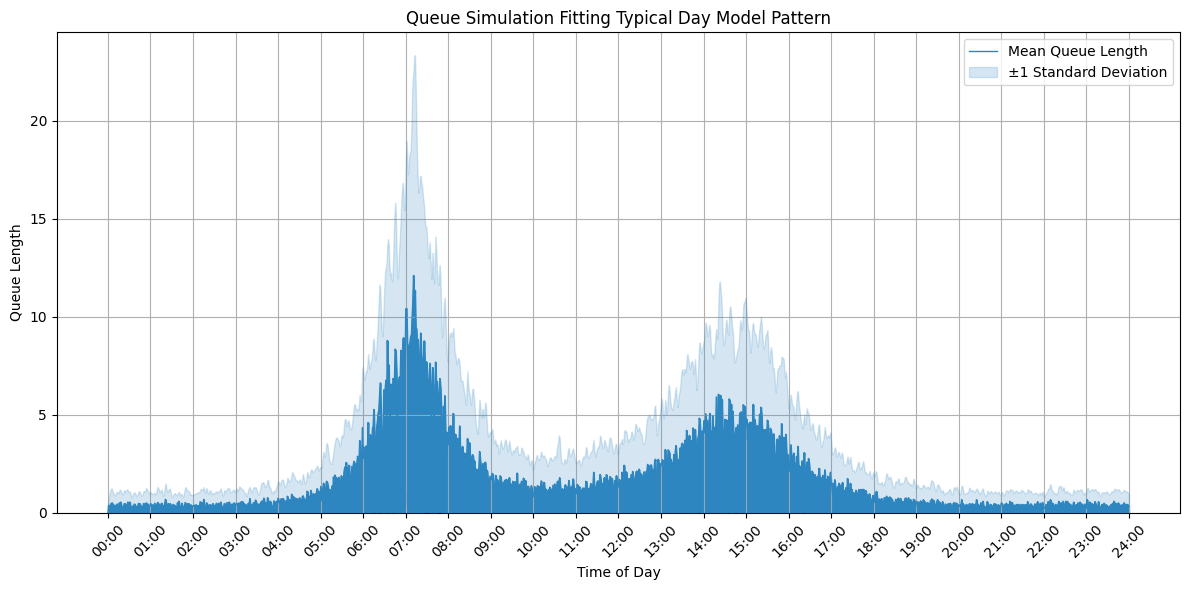


Simulation Statistics (Last Run):
average_queue_length: 2.84
max_queue_length: 31.00
total_arrivals: 111328.00
total_departures: 111327.00
rejected_arrivals: 0.00
average_waiting_time: 0.02
max_waiting_time: 0.25
min_waiting_time: 0.00


In [10]:
def arrival_rate(t, base_rate=40, peaks=None):
    """
    Calculates arrival rate at time t based on GMM components
    
    Parameters:
    t (float): Time in minutes from midnight
    base_rate (float): Background traffic flow rate (cars per minute)
    peaks (list): List of dictionaries for each peak period
    
    Returns:
    rate (float): Arrival rate at time t
    """
    if peaks is None:
        peaks = [
            # Morning peak (around 7:00)
            {"amplitude": 90, "time": 420, "width": 90},  # 7 AM
            
            # Mid-morning peak (around 11:00)
            {"amplitude": 30, "time": 660, "width": 120},  # 11 AM
            
            # Afternoon peak (around 15:00)
            {"amplitude": 80, "time": 900, "width": 120},  # 3 PM
        ]
    
    rate = base_rate
    for peak in peaks:
        A = peak["amplitude"]
        t_peak = peak["time"]
        sigma = peak["width"]
        # Gaussian peak addition
        rate += A * np.exp(-((t - t_peak)**2) / (2 * sigma**2))
    
    return rate

def service_rate(t):
    return 150  # cars per minute

if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    N_simulations = 50  # Number of simulation runs
    fixed_time_points = np.arange(0, 1441)  # Fixed time grid from 0 to 1440
    resampled_queue_lengths = np.zeros((N_simulations, len(fixed_time_points)))
    
    # Run multiple simulations
    for i in range(N_simulations):
        sim = NonStationaryMM1(
            arrival_rate_func=lambda t: arrival_rate(t),
            service_rate_func=service_rate,
            T_end=1440,
            initial_queue_length=0,
            max_queue_length=20000,
            time_step=1
        )
        
        sim.run_simulation()
        
        f = interp1d(sim.time_history, sim.queue_length_history, 
                    kind='previous', fill_value='extrapolate')
        resampled_queue_lengths[i] = f(fixed_time_points)

    # Calculate statistics
    mean_queue = np.mean(resampled_queue_lengths, axis=0)
    std_queue = np.std(resampled_queue_lengths, axis=0)

    # Smooth the standard deviation for the bands
    smoothing_sigma = 1
    mean_queue_smooth = gaussian_filter1d(mean_queue, smoothing_sigma)
    std_queue_smooth = gaussian_filter1d(std_queue, smoothing_sigma)

    # Calculate bounds
    std_factor = 1.0  # ±1 standard deviation
    lower_bound = np.maximum(0, mean_queue_smooth - std_queue_smooth * std_factor)
    upper_bound = mean_queue_smooth + std_queue_smooth * std_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot mean queue length with fill
    plt.fill_between(fixed_time_points, 0, mean_queue,
                    color='#2E86C1', alpha=1)
    
    # Plot the mean line
    plt.plot(fixed_time_points, mean_queue,
            color='#2E86C1', linewidth=1.0,
            label='Mean Queue Length')
    
    # Plot the standard deviation as a shaded band
    plt.fill_between(fixed_time_points, 
                    lower_bound, 
                    upper_bound,
                    color='#2E86C1', alpha=0.2,
                    label='±1 Standard Deviation',
                    zorder=5)

    def minutes_to_timestring(minutes):
        hours = int(minutes // 60)
        mins = int(minutes % 60)
        return f"{hours:02d}:{mins:02d}"

    xticks = np.arange(0, 1441, 60)
    xtick_labels = [minutes_to_timestring(x) for x in xticks]
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel('Time of Day')
    plt.ylabel('Queue Length')
    plt.title('Queue Simulation Fitting Typical Day Model Pattern')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(bottom=0)
    
    plt.savefig('data/queue_typical.png')
    plt.show()

    # Print statistics
    stats = sim.get_statistics()
    print("\nSimulation Statistics (Last Run):")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")


### Staggered school start times 

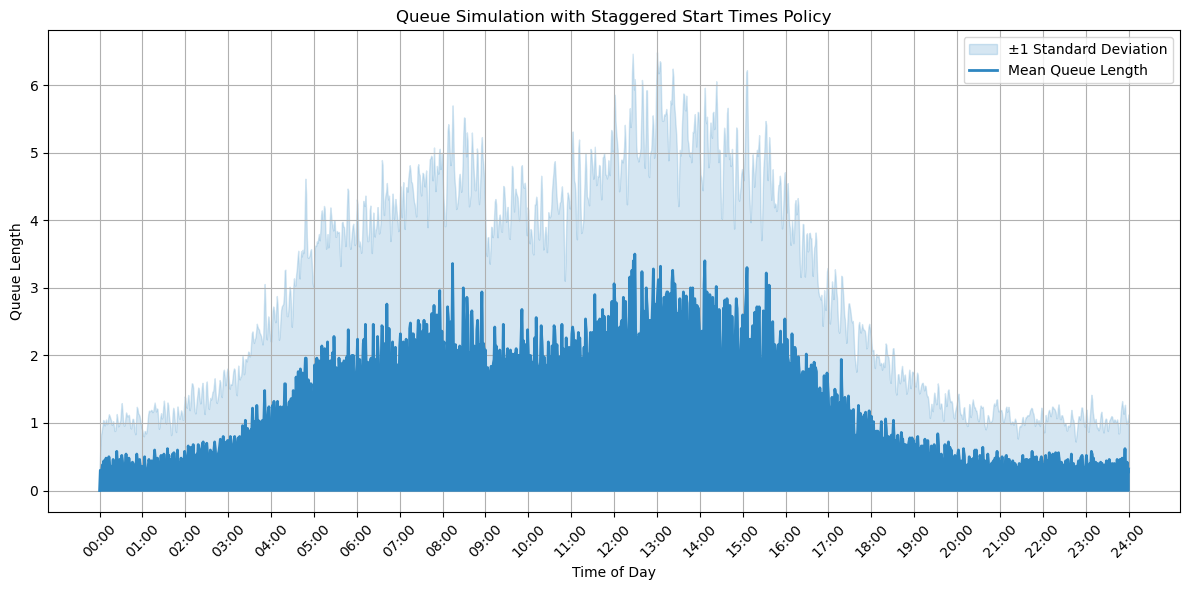


Simulation Statistics (Last Run):
average_queue_length: 2.08
max_queue_length: 21.00
total_arrivals: 110978.00
total_departures: 110977.00
rejected_arrivals: 0.00
average_waiting_time: 0.02
max_waiting_time: 0.18
min_waiting_time: 0.00


In [6]:
def arrival_rate(t, base_rate=40, peaks=None):
    """
    [Keep your existing arrival_rate function exactly as is]
    """
    if peaks is None:
        peaks = [
            # MORNING PEAK  1 (around 5:00)
            {"amplitude": 45, "time": 300, "width": 90},  # 5 AM
            
            # MORNING PEAK 2 (around 8:00)
            {"amplitude": 45, "time": 480, "width": 90},  # 7 AM

            # Mid-morning peak (around 11:00)
            {"amplitude": 30, "time": 660, "width": 120},  # 11 AM
            
            # AFTERNOON PEAK 1 (around 13:00)
            {"amplitude": 35, "time": 780, "width": 120},  # 1 PM

            # AFTERNOON PEAK 2 (around 16:00)
            {"amplitude": 45, "time": 960, "width": 120},  # 4 PM
        ]
    
    rate = base_rate
    for peak in peaks:
        A = peak["amplitude"]
        t_peak = peak["time"]
        sigma = peak["width"]
        rate += A * np.exp(-((t - t_peak)**2) / (2 * sigma**2))
    
    return rate

def service_rate(t):
    return 150  # cars per minute
    
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    N_simulations = 50  # Number of simulation runs
    fixed_time_points = np.arange(0, 1441)  # Fixed time grid from 0 to 1440
    resampled_queue_lengths = np.zeros((N_simulations, len(fixed_time_points)))
    
    # Run multiple simulations
    for i in range(N_simulations):
        sim = NonStationaryMM1(
            arrival_rate_func=lambda t: arrival_rate(t),
            service_rate_func=service_rate,
            T_end=1440,
            initial_queue_length=0,
            max_queue_length=20000,
            time_step=1
        )
        
        sim.run_simulation()
        
        f = interp1d(sim.time_history, sim.queue_length_history, 
                    kind='previous', fill_value='extrapolate')
        resampled_queue_lengths[i] = f(fixed_time_points)

    # Calculate statistics
    mean_queue = np.mean(resampled_queue_lengths, axis=0)
    std_queue = np.std(resampled_queue_lengths, axis=0)

    # Smooth the standard deviation for the bands
    smoothing_sigma = 1
    mean_queue_smooth = gaussian_filter1d(mean_queue, smoothing_sigma)
    std_queue_smooth = gaussian_filter1d(std_queue, smoothing_sigma)

    # Calculate bounds
    std_factor = 1.0  # ±1 standard deviation
    lower_bound = np.maximum(0, mean_queue_smooth - std_queue_smooth * std_factor)
    upper_bound = mean_queue_smooth + std_queue_smooth * std_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot the standard deviation as a shaded band FIRST (so it's in background)
    plt.fill_between(fixed_time_points, 
                    lower_bound, 
                    upper_bound,
                    color='#2E86C1', alpha=0.2,
                    label='±1 Standard Deviation',
                    zorder=1)
    
    # Plot mean queue length with solid fill
    plt.fill_between(fixed_time_points, 0, mean_queue,
                    color='#2E86C1', alpha=1,
                    zorder=2)
    
    # Plot the mean line ON TOP to emphasize it
    plt.plot(fixed_time_points, mean_queue,
            color='#2E86C1', linewidth=2.0,  # Made line thicker
            label='Mean Queue Length',
            zorder=3)

    plt.legend(loc='upper right') 
    def minutes_to_timestring(minutes):
        hours = int(minutes // 60)
        mins = int(minutes % 60)
        return f"{hours:02d}:{mins:02d}"

    xticks = np.arange(0, 1441, 60)
    xtick_labels = [minutes_to_timestring(x) for x in xticks]
    plt.xticks(xticks, xtick_labels, rotation=45)

    plt.xlabel('Time of Day')
    plt.ylabel('Queue Length')
    plt.title('Queue Simulation with Staggered Start Times Policy')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/queue_policy.png')
    plt.show()

    # Print statistics
    stats = sim.get_statistics()
    print("\nSimulation Statistics (Last Run):")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")
